In [1]:
import joblib
import numpy as np
import pandas as pd
import yaml
from brand import initializeRedisFromYAML
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split

from utils import get_lagged_features, load_stream


In [2]:
# Connect to Redis
r = initializeRedisFromYAML('replayTest.yaml')

connecting to Redis using: replayTest.yaml
Redis Socket Path /var/run/redis.sock
Initialized Redis


In [3]:
with open('stream_spec.yaml', 'r') as f:
    stream_spec = yaml.safe_load(f)

In [4]:
# Load data from Redis
# taskInput
task_input = load_stream(r, 'taskInput', stream_spec=stream_spec)
task_input = task_input.set_index('timestamps')

# thresholdCrossings
threshold_crossings = load_stream(r,
                                  'thresholdCrossings',
                                  stream_spec=stream_spec)

# Separate channels into their own columns
tc_timestamps = threshold_crossings['timestamps'].values
crossings = np.stack(threshold_crossings['crossings'])
n_chans = crossings.shape[1]

channel_labels = [f'ch{i :03d}' for i in range(n_chans)]
tc_df = pd.DataFrame(crossings,
                     index=tc_timestamps + 13,
                     columns=channel_labels)


In [5]:
joined_df = task_input.join(tc_df, how='inner')
joined_df.index = pd.to_timedelta(joined_df.index / 30, unit='ms')

In [6]:
# split the behavioral data into columns
samples = np.stack(joined_df['samples'])
joined_df['touch'] = samples[:, 0]
joined_df['x'] = samples[:, 1]
joined_df['y'] = samples[:, 2]

In [7]:
bin_size_ms = 5  # ms
binned_data = joined_df.resample(f'{bin_size_ms :d}ms').mean().dropna(axis=0)
binned_data

,BRANDS_time,udp_recv_time,ch000,ch001,ch002,ch003,ch004,ch005,ch006,ch007,...,ch089,ch090,ch091,ch092,ch093,ch094,ch095,touch,x,y
00:45:15.803000,1.636045e+09,1.636045e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,266.0,15.0,-7.8
00:45:15.808000,1.636045e+09,1.636045e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,265.8,14.0,-9.2
00:45:15.813000,1.636045e+09,1.636045e+09,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,...,0.0,0.0,0.2,0.0,0.0,0.0,0.0,264.6,12.4,-7.8
00:45:15.818000,1.636045e+09,1.636045e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,264.0,12.2,-7.4
00:45:15.823000,1.636045e+09,1.636045e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.2,0.0,0.0,0.0,0.2,0.0,0.0,264.8,12.6,-9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
00:46:43.618000,1.636045e+09,1.636045e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.2,0.0,0.0,0.0,0.0,263.6,34.0,1209.2
00:46:43.623000,1.636045e+09,1.636045e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,265.0,31.4,1270.2
00:46:43.628000,1.636045e+09,1.636045e+09,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,...,0.2,0.0,0.0,0.0,0.0,0.0,0.0,264.0,31.4,1305.8
00:46:43.633000,1.636045e+09,1.636045e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,263.8,34.4,1369.0


In [8]:
# Decoding
neural_data = binned_data[channel_labels].values

X = get_lagged_features(neural_data, n_history=50)
y = binned_data[['x', 'y']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

with joblib.parallel_backend('loky'):
    mdl = RidgeCV(alphas=np.logspace(-1, 3, 20))
mdl.fit(X_train, y_train)

print(f'Best L2: {mdl.alpha_}')
print(f'Train R^2: {mdl.score(X_train, y_train)}')
print(f'Test R^2: {mdl.score(X_test, y_test)}')

y_pred = mdl.predict(X)
binned_data['x_pred'] = y_pred[:, 0]
binned_data['y_pred'] = y_pred[:, 1]

In [ ]:
# Split the data into trials
# state: [start_trial, movement, reward, failure, between_trials]
state = load_stream(r, 'state', stream_spec=stream_spec)
state.sort_values('sync', inplace=True)

In [ ]:
# Assign trial numbers
state['trial_id'] = None  # make a new column

# number the 'start_trial' tokens
mask = state['state'] == 'start_trial'
state.loc[mask, 'trial_id'] = np.arange(len(state[mask]))

# assign the 'start_trial' number to tokens that come after it
current_trial = None
trial_ids = np.empty_like(state['trial_id'])
for i in range(state.shape[0]):
    if state['trial_id'].iloc[i] is not None:
        current_trial = state['trial_id'].iloc[i]
    trial_ids[i] = current_trial
state['trial_id'] = trial_ids

In [ ]:
trials = state.pivot(index='trial_id', columns='state', values='sync')
trials.sort_index(axis=1, inplace=True)  # sort columns after pivoting
trials.dropna(axis=0, inplace=True)  # drop incomplete trials
trials = trials / 30  # convert to milliseconds
for field in trials.columns:
    trials[field] = pd.to_timedelta(trials[field], unit='ms')
trials

state,failure,movement,start_trial
trial_id,,,
0,00:45:52.257000,00:45:48.256000,00:45:18.587000
1,00:46:03.021000,00:45:59.019000,00:45:53.490000
2,00:46:09.916000,00:46:05.915000,00:46:04.044000
3,00:46:16.950000,00:46:12.950000,00:46:11.466000
4,00:46:23.184000,00:46:19.183000,00:46:18.345000
...,...,...,...
82,00:55:28.261000,00:55:24.260000,00:55:20.826000
83,00:55:34.795000,00:55:30.794000,00:55:29.790000
84,00:55:40.390000,00:55:36.389000,00:55:35.913000


In [ ]:
trial_dfs = []
align_field = 'movement'
start_offset, end_offset = pd.to_timedelta((-500, 1000), unit='ms')
bin_width = pd.to_timedelta(bin_size_ms, unit='ms')
for tid in trials.index.values:
    center = trials[align_field].loc[tid]
    a = center + start_offset
    b = center + end_offset
    trial_df = binned_data.loc[a:b].copy()
    trial_df['trial_id'] = tid
    trial_df['align_time'] = trial_df.index.ceil(bin_width) - center.ceil(
        bin_width)
    trial_dfs.append(trial_df)

# Combine all trials into one DataFrame
trial_data = pd.concat(trial_dfs, ignore_index=True)

In [ ]:
aligned_trials = trial_data.pivot_table(index='align_time', columns='trial_id')

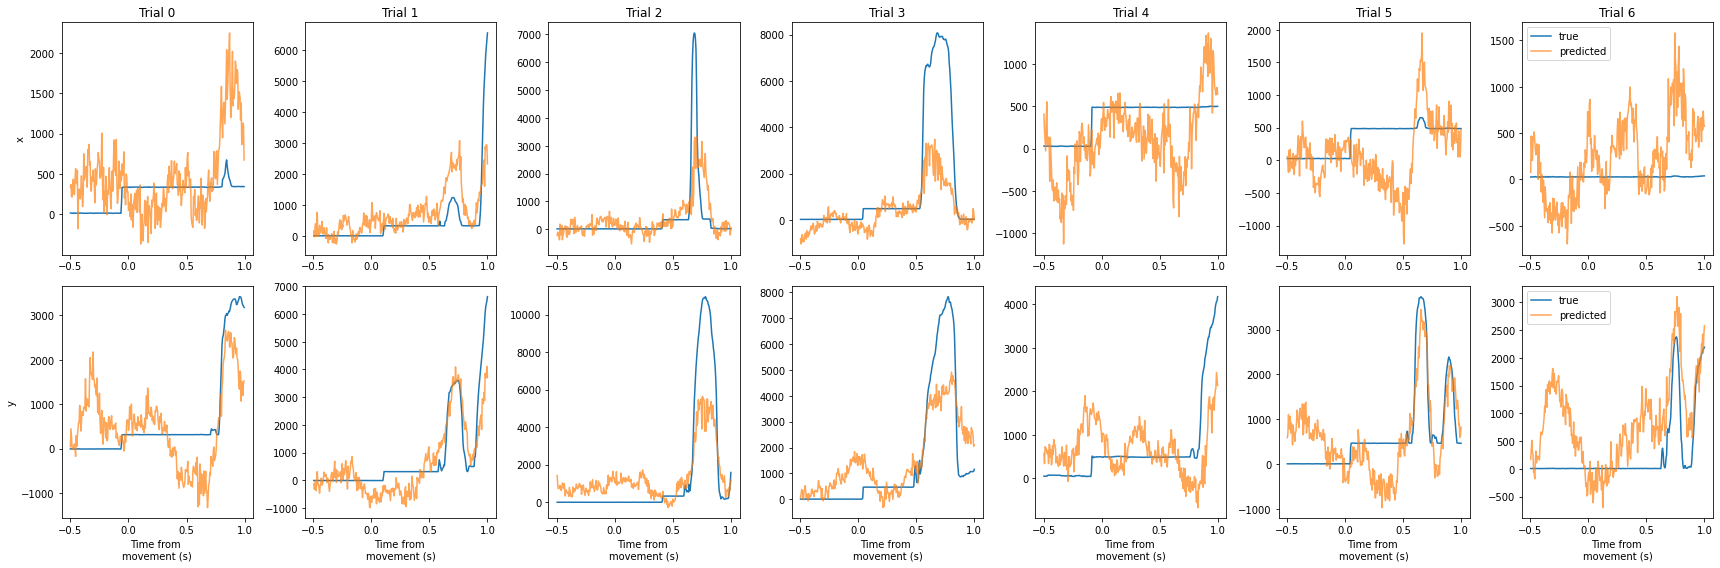

In [ ]:
import matplotlib.pyplot as plt

trial_ids = trial_data['trial_id'].unique()

fig, axes = plt.subplots(nrows=2, ncols=len(trial_ids), figsize=(24, 8))

for i, trial_id in enumerate(trial_ids):
    t = aligned_trials.index.total_seconds()
    axes[0, i].plot(t, aligned_trials['x'][trial_id], label='true')
    axes[0, i].plot(t,
                    aligned_trials['x_pred'][trial_id],
                    label='predicted',
                    alpha=0.7)
    axes[0, i].set_title(f'Trial {trial_id}')
    axes[1, i].plot(t, aligned_trials['y'][trial_id], label='true')
    axes[1, i].plot(t,
                    aligned_trials['y_pred'][trial_id],
                    label='predicted',
                    alpha=0.7)
    axes[1, i].set_xlabel(f'Time from \n{align_field} (s)')
axes[0, 0].set_ylabel('x')
axes[1, 0].set_ylabel('y')
axes[0, -1].legend()
axes[1, -1].legend()

plt.tight_layout()
plt.savefig('force_predictions.pdf')